In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import seaborn as sns
import folium
import folium.plugins as plugins

In [41]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [42]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [43]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Preparation
## Trip Duration Clean-up
Deal with **outliers** associated with the `trip_duration` variable  
Exclude data that lies outside 2 standard deviations from the mean. 

In [45]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

## Check latitude/longitude bounds
Latitude: -85 to +85, Longitude: -180 to +180

In [46]:
print('Latitude bounds: {} to {}'.format(
    max(train.pickup_latitude.min(), train.dropoff_latitude.min()),
    max(train.pickup_latitude.max(), train.dropoff_latitude.max())
))

Latitude bounds: 34.359695434570305 to 51.88108444213867


In [47]:
print('Longitude bounds: {} to {}'.format(
    max(train.pickup_longitude.min(), train.dropoff_longitude.min()),
    max(train.pickup_longitude.max(), train.dropoff_longitude.max())
))

Longitude bounds: -121.9333038330078 to -61.33552932739258


## Latitude and Longitude Clean-up

Below shows the borders of NY City by Google Map.  
Then get the border ranges in coordinates.

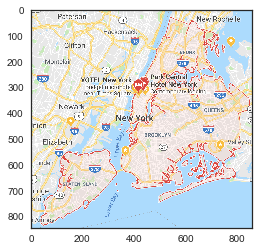

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('NYC.png')
plt.imshow(img1)
plt.show()

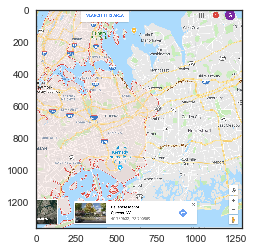

In [49]:
img2 = mpimg.imread('NYC East.png')
plt.imshow(img2)
plt.show()

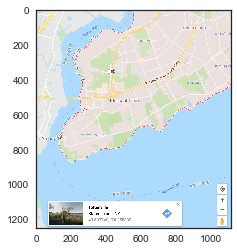

In [50]:
img3 = mpimg.imread('NYC West.png')
plt.imshow(img3)
plt.show()

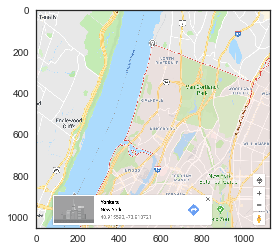

In [51]:
img4 = mpimg.imread('NYC North.png')
plt.imshow(img4)
plt.show()

Time taken by above cell is 1.6633918285369873.


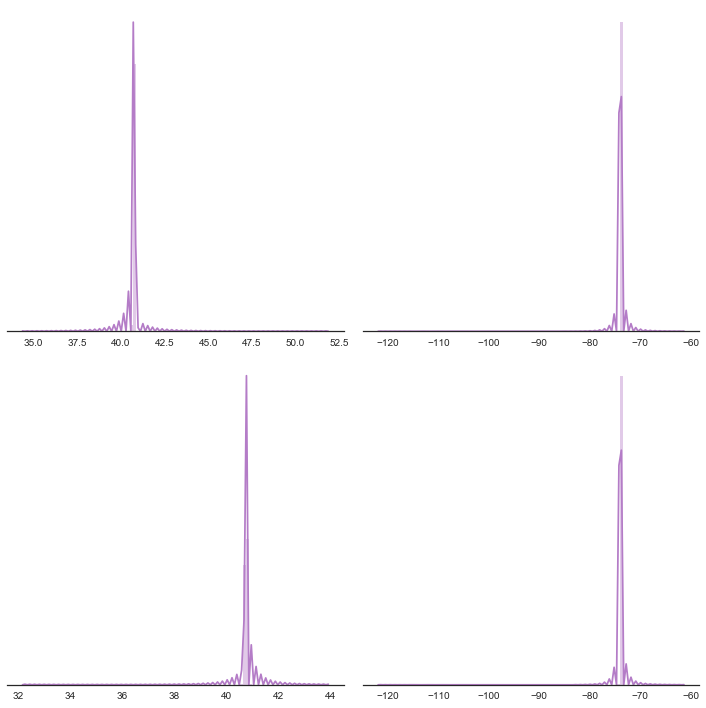

In [52]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

The borders of NY City, in coordinates comes out to be:

city_long_border = (-74.255, -73.701)  
city_lat_border = (40.508, 40.916) 

From the coordinates above, we can limit our area of investigation to within the NY City borders.

In [53]:
city_long_x=-74.255
city_long_y=-73.701
city_lat_x =40.508
city_lat_y=40.916
train = train[train['pickup_longitude'] <= city_long_y]
train = train[train['pickup_longitude'] >= city_long_x]
train = train[train['pickup_latitude'] <= city_lat_y]
train = train[train['pickup_latitude'] >= city_lat_x]
train = train[train['dropoff_longitude'] <= city_long_y]
train = train[train['dropoff_longitude'] >= city_long_x]
train = train[train['dropoff_latitude'] <= city_lat_y]
train = train[train['dropoff_latitude'] >= city_lat_x]

## Check Missing Values 
check whether we have data missing in the train and the test set.

In [54]:
print(train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [55]:
print(test.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


**Good! no N/A values**

## Check for duplicate ids

In [56]:
print('No of Duplicates, Trip IDs: {}'.format(len(train) - 
                                              len(train.drop_duplicates(subset='id'))))

No of Duplicates, Trip IDs: 0


## Check Number of Passengers
The common sense implies values between 1 and 10, we should check 0

In [57]:
print('Passengers: {} to {}'.format(train.passenger_count.min(), 
                                        train.passenger_count.max()))

Passengers: 0 to 9


## Passenger_Count Clean-up

let's also drop trips with passenger count = 0

In [58]:
print('Empty trips: {}'.format(train[train.passenger_count == 0].shape[0]))
train = train[train.passenger_count > 0]

Empty trips: 59


In [59]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_hour'] = pd.DatetimeIndex(train['dropoff_datetime']).hour
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
total_rows = len(train.index)

In [62]:
heat_df =train.sample(n=10000)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_hour', 'pickup_latitude', 'pickup_longitude','pickup_hour']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)
heat_df['pickup_latitude'] = heat_df['pickup_latitude'].astype(float)
heat_df['pickup_longitude'] = heat_df['pickup_longitude'].astype(float)

#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
#heat_df['Weight'] = heat_df['dropoff_hour']
heat_df['dropoff_hour'] = heat_df['dropoff_hour'].astype(float)
heat_df['pickup_hour'] = heat_df['pickup_hour'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'dropoff_hour','pickup_latitude','pickup_longitude', 'pickup_hour'])

In [63]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['dropoff_hour'] == i].iterrows()] 
                 for i in range(0,24)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

# Display the map
newyork_on_heatmap

In [64]:
heat_data_pickup = [[[row['pickup_latitude'],row['pickup_longitude']] 
                for index, row in heat_df[heat_df['pickup_hour'] == i].iterrows()] 
                 for i in range(0,24)]
newyork_on_heatmap_1 = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13)
hm = plugins.HeatMapWithTime(heat_data_pickup,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap_1)

# Display the map
newyork_on_heatmap_1